In [1]:
import requests
from datetime import datetime

import os
from apiclient.http import MediaFileUpload, MediaIoBaseDownload
from google.oauth2 import service_account
from googleapiclient.discovery import build

def setup_gdrive(credentials_secret):
    with open('credentials.json', 'w') as f:
        f.write(os.environ[credentials_secret])
        
    # Load the credentials from the JSON key file
    credentials = service_account.Credentials.from_service_account_file(
        'credentials.json',
        scopes=['https://www.googleapis.com/auth/drive']
    )

    drive_service = build('drive', 'v3', credentials=credentials)
    return drive_service



In [123]:
with open('/Users/przivic/Downloads/quetiene-3acd3a3a2117.json') as f:
    credentials = f.read()

os.environ['GDRIVE_SECRET'] = credentials

In [124]:
drive_service = setup_gdrive('GDRIVE_SECRET')
response = drive_service.files().list().execute()

    


In [125]:
response = drive_service.files().list().execute()
files = response['files']
files

[{'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1s_j644Z1eR4av3X8UJGsj5xvlUsKhFmT',
  'name': 'demanda-enre-2024-02-11T12-1078.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1qUB52EP_sw3l22b3bR44wH8Vnc3NZSIt',
  'name': 'demanda-enre-2024-02-11T12-1077.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1hF8c7gO5JYkJw8oBroBrYuoP4zwb-VCi',
  'name': 'cortes-enre-2024-02-11T12.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1mRndJSlG3jHYjjrRJ3ZuTX1PKr96J4NY',
  'name': 'demanda-enre-2024-02-11T11-1078.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1-x1tdHhvH42Rrs5_aMdZwBkE9la1hak1',
  'name': 'demanda-enre-2024-02-11T11-1077.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1_j0MAbzi0kwQe8jeFeWVfcmfWTEn5w5b',
  'name': 'cortes-enre-2024-02-11T11.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1GXB6yDVwwrw_6GWv_fKdJ3_G7uvckXsl',
  'name': 'demanda-enre-2024-02-1

In [126]:
import os

if not os.path.exists('data'): os.makedirs('data')

for file in files:
    file_id = file['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    with open('data/' + file['name'], 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            print(f"Download {int(status.progress() * 100)}%. {file_id}")

Download 100%. 1s_j644Z1eR4av3X8UJGsj5xvlUsKhFmT
Download 100%. 1qUB52EP_sw3l22b3bR44wH8Vnc3NZSIt
Download 100%. 1hF8c7gO5JYkJw8oBroBrYuoP4zwb-VCi
Download 100%. 1mRndJSlG3jHYjjrRJ3ZuTX1PKr96J4NY
Download 100%. 1-x1tdHhvH42Rrs5_aMdZwBkE9la1hak1
Download 100%. 1_j0MAbzi0kwQe8jeFeWVfcmfWTEn5w5b
Download 100%. 1GXB6yDVwwrw_6GWv_fKdJ3_G7uvckXsl
Download 100%. 1dCneWk65Hf-8Idfvoc3GHH49tzMaCUBs
Download 100%. 1IAS_2R6ATGezGna48Wt9PenVZttums8D
Download 100%. 1RxCJzSkARqiHEH_e13Jert7qCMvgqmIM
Download 100%. 1akGhn0vwtsll4tQAsFMR7840IKwBXjiq
Download 100%. 1goEmTOpKdV24vtnvlLdnAxlBHa-1jLtP
Download 100%. 1wKtIOIWQ1AvxyQ2jXty_mnSc5nmMlo1y
Download 100%. 1yQHG1e8ZUfZrXDzXBAuffdPw8yTOCQcv
Download 100%. 1PPOuFWOkWcqYjTth2aapDUy24UWQ8waY
Download 100%. 1MCXPMaA5KB6y_l5Y6_Ge-g2aCQZ3icg4
Download 100%. 1mN-xy8Y2E60GZhc8UDypbELxbUkUa8pT
Download 100%. 16aTKyvDYSepCnaxe42aMsT-rfVnZSFGr
Download 100%. 1trN1AVgwTr_Lpbc7PxIS-UwP-gtQ3t8F
Download 100%. 1nK_IoJKIw3EstGv2pN94SlFKEgCiVlmO
Download 100%. 1xcF7

In [96]:
import json
import re
import os

def parse_fname_date(fname):
    date_pat = re.compile('(\d{4}-\d{2}-\d{2}T\d{2})')
    return datetime.strptime(date_pat.search(fname).group(0), '%Y-%m-%dT%H')

def parse_cortes(fname):
    with open(fname) as f:
        contents = f.read()

    var_pat = re.compile('addressPoints_Cuadro_D.*?=.*?(?P<lista>.*?);')
    lista = var_pat.search(contents).groupdict()['lista'].strip()[1:-1].strip()

    corte_pat = re.compile('(\[.*?\])')
    cortes = []
    fname_date = parse_fname_date(fname)
    keys = ['latitud', 'longitud', 'misc', 'descr']
    for corte_match in corte_pat.finditer(lista):
        corte = json.loads(corte_match.group(0))
        corte = dict(zip(keys, corte))
        
        lines = corte['descr'].split(',')
        descr_dict = {'tipo': lines[0], 'empresa': lines[1].strip()}
        for line in lines[2:]:
            colon_pos = line.find(':')
            k = line[:colon_pos].strip()
            v = line[colon_pos+1:].strip()
            descr_dict[k.strip().lower()] = v.strip()

        corte.update(descr_dict)
        corte['date_hour'] = fname_date

        cortes.append(corte)
        
    return cortes

In [186]:
def parse_demanda(fname):
    region = int(fname.split('-')[-1].split('.')[0])
    with open(fname) as f:
        res = json.load(f)
        for doc in res:
            doc['region'] = region
            doc['fecha'] = datetime.strptime(doc['fecha'][:19], '%Y-%m-%dT%H:%M:%S')
    return res

In [183]:
fname = 'data/' + os.listdir('data')[1]

In [137]:
import gzip

fname = 'clima-enre-2024-02-11T13.txt'
with open(fname) as f:
    clima_content = f.read()

In [180]:
from datetime import timedelta

data = clima_content.split(';')[0]
parsed_data = json.loads(data[6:].replace("'", '"'))
keys = ['hour', 'edesur', 'edenor', 'codigo', 'estado_cielo', 'temperatura']
parsed_data = [dict(zip(keys, row)) for row in parsed_data]

fname_date = parse_fname_date(fname)

hour, minute = map(int, parsed_data[-1]['hour'].split(':'))
parsed_data[-1]['datetime'] = fname_date.replace(hour=hour, minute=minute)

for i in range(len(parsed_data)-2, -1, -1):
    current_row = parsed_data[i]
    current_time = datetime.strptime(current_row['hour'], '%H:%M')
    
    prev_row = parsed_data[i+1]
    prev_time = datetime.strptime(prev_row['hour'], '%H:%M')
    
    delta = (prev_time - current_time)
    if delta.total_seconds() < 0:
        delta += timedelta(days=1)
        
    current_row['datetime'] = prev_row['datetime'] - delta

In [182]:
demanda[0]

{'fecha': datetime.datetime(2024, 2, 11, 0, 0),
 'demHoy': 3651,
 'demAyer': 3389,
 'demSemanaAnt': 3538,
 'region': 1077}

In [181]:
parsed_data

[{'hour': '13:20',
  'edesur': 13044,
  'edenor': 3043,
  'codigo': '04d',
  'estado_cielo': 'Muy Nuboso ',
  'temperatura': '28',
  'datetime': datetime.datetime(2024, 2, 10, 13, 20)},
 {'hour': '13:25',
  'edesur': 13044,
  'edenor': 3043,
  'codigo': '04d',
  'estado_cielo': 'Muy Nuboso ',
  'temperatura': '28',
  'datetime': datetime.datetime(2024, 2, 10, 13, 25)},
 {'hour': '13:30',
  'edesur': 13044,
  'edenor': 3043,
  'codigo': '04d',
  'estado_cielo': 'Muy Nuboso ',
  'temperatura': '28',
  'datetime': datetime.datetime(2024, 2, 10, 13, 30)},
 {'hour': '13:35',
  'edesur': 13060,
  'edenor': 3034,
  'codigo': '04d',
  'estado_cielo': 'Muy Nuboso ',
  'temperatura': '29',
  'datetime': datetime.datetime(2024, 2, 10, 13, 35)},
 {'hour': '13:40',
  'edesur': 13060,
  'edenor': 3034,
  'codigo': '04d',
  'estado_cielo': 'Muy Nuboso ',
  'temperatura': '29',
  'datetime': datetime.datetime(2024, 2, 10, 13, 40)},
 {'hour': '13:45',
  'edesur': 13060,
  'edenor': 3034,
  'codigo': '0

In [171]:
current_time

datetime.datetime(1900, 1, 1, 23, 55)

In [172]:
prev_time

datetime.datetime(1900, 1, 1, 0, 0)

In [170]:
prev_row['datetime']

datetime.datetime(2024, 2, 11, 0, 0)

In [168]:
prev_row

{'hour': '00:00',
 'edesur': 42799,
 'edenor': 3474,
 'codigo': '01n',
 'estado_cielo': 'Cielo Claro ',
 'temperatura': '27',
 'datetime': datetime.datetime(2024, 2, 11, 0, 0)}

In [169]:
current_row

{'hour': '23:55',
 'edesur': 42799,
 'edenor': 3474,
 'codigo': '01n',
 'estado_cielo': 'Cielo Claro ',
 'temperatura': '27'}

In [162]:
prev_row['datetime'] - (prev_time - current_time)

datetime.datetime(2024, 2, 11, 13, 10)

In [157]:
current_row

{'hour': '13:10',
 'edesur': 30406,
 'edenor': 2647,
 'codigo': '02d',
 'estado_cielo': 'Algo De Nubes ',
 'temperatura': '34'}

In [158]:
prev_row

{'hour': '13:15',
 'edesur': 30421,
 'edenor': 2647,
 'codigo': '02d',
 'estado_cielo': 'Algo De Nubes ',
 'temperatura': '32',
 'datetime': datetime.datetime(2024, 2, 11, 13, 15)}

In [100]:
cortes = []
demanda = []

for fname in os.listdir('data'):
    if fname.startswith('cortes'):
        parsing_func = parse_cortes
        output_list = cortes
    else:
        parsing_func = parse_demanda
        output_list = demanda
        
    fname = 'data/' + fname
    output_list.extend(parsing_func(fname))
    

In [101]:
for doc in demanda:
    doc['fecha'] = datetime.strptime(doc['fecha'][:19], '%Y-%m-%dT%H:%M:%S')

In [102]:
import pandas as pd

demanda_df = pd.DataFrame(demanda)

In [103]:
demanda_df.drop_duplicates(subset=['fecha', 'region'], inplace=True)

In [74]:
len(demanda_df)

578

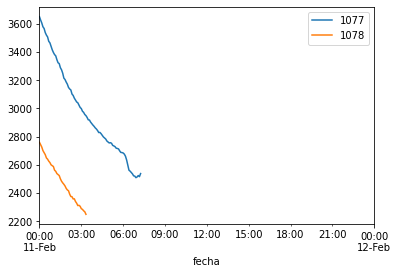

In [80]:
import matplotlib.pyplot as plt

for region in demanda_df.region.unique():
    demanda_df[demanda_df.region==region].set_index('fecha').demHoy.plot(label=str(region))
    
plt.legend(loc='best')

In [119]:
cortes_df = pd.DataFrame(cortes)
cortes_df['usuarios afectados'] = cortes_df['usuarios afectados'].apply(int)

In [120]:
demanda[:10]

[{'fecha': datetime.datetime(2024, 2, 11, 0, 0),
  'demHoy': 3651,
  'demAyer': 3389,
  'demSemanaAnt': 3538,
  'region': 1077},
 {'fecha': datetime.datetime(2024, 2, 11, 0, 5),
  'demHoy': 3627,
  'demAyer': 3365,
  'demSemanaAnt': 3516,
  'region': 1077},
 {'fecha': datetime.datetime(2024, 2, 11, 0, 10),
  'demHoy': 3606,
  'demAyer': 3344,
  'demSemanaAnt': 3495,
  'region': 1077},
 {'fecha': datetime.datetime(2024, 2, 11, 0, 15),
  'demHoy': 3579,
  'demAyer': 3331,
  'demSemanaAnt': 3471,
  'region': 1077},
 {'fecha': datetime.datetime(2024, 2, 11, 0, 20),
  'demHoy': 3567,
  'demAyer': 3315,
  'demSemanaAnt': 3458,
  'region': 1077},
 {'fecha': datetime.datetime(2024, 2, 11, 0, 25),
  'demHoy': 3538,
  'demAyer': 3296,
  'demSemanaAnt': 3430,
  'region': 1077},
 {'fecha': datetime.datetime(2024, 2, 11, 0, 30),
  'demHoy': 3520,
  'demAyer': 3286,
  'demSemanaAnt': 3409,
  'region': 1077},
 {'fecha': datetime.datetime(2024, 2, 11, 0, 35),
  'demHoy': 3507,
  'demAyer': 3271,
  'de

In [118]:
import folium
from folium.plugins import HeatMap

# Create a base map using OpenStreetMap

m = folium.Map(location=[cortes_df.latitud.median(), cortes_df.longitud.median()], zoom_start=12)

# Sample data points (replace with your own data)
# data_points = [(latitude1, longitude1), (latitude2, longitude2), ...]
data_points = []
for doc in cortes_df.groupby(['latitud', 'longitud']):
    data_points.append((doc['latitud'], doc['longitud'], int(doc['usuarios afectados'])))

# Add a heatmap layer
HeatMap(data_points, radius=20).add_to(m)

# OR
m

In [106]:
# Import libraries
import folium
import pandas as pd

# Sample data (replace with your actual data)
data = pd.DataFrame({'lat': [51.5074, 51.5085, 51.5110],
                   'lon': [-0.1278, -0.1257, -0.1207],
                   'value': [10, 20, 5]})

# Create base map
m = folium.Map(location=[51.5074, -0.1278], zoom_start=13, tiles='Stamen TonerLite')

# Create heatmap
folium.Heatmap(data[['lat', 'lon', 'value']], radius=15, gradient={0.2: 'green', 0.6: 'yellow', 1: 'red'}).add_to(m)

# Display map
m

ValueError: Custom tiles must have an attribution.

In [105]:
cortes_df.groupby('alimentador').latitud.nunique()

alimentador
N:                                           76
N:089-1-14/089-1-14                           1
N:SAN JUSTO/164-TR1/164-5518                  1
R:                                           97
R:020-4-45/020-4-45                           1
R:022-1-15/022-1-15                           1
R:023-1-14/023-1-14                           4
R:073-4-46/073-4-46                           1
R:077-3-34/077-3-34                          12
R:079-5-54/079-5-54                           5
R:089-1-16/089-1-16                           1
R:113-1-17/113-1-17                           8
R:122-4-41/122-4-41                           5
R:122-4-43/122-4-43                          12
R:122-4-45/122-4-45                           2
R:122-4-47/122-4-47                           8
R:143-3-36/143-3-36                           3
R:147-2-22/147-2-22                           1
R:172-2-26/172-2-26                           6
R:179-2-22/179-2-22                           1
R:182-1-16/182-1-16         

In [95]:
cortes_df[cortes_df.alimentador == ': R:077-3-34/077-3-34']

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour
134,-34.698348,-58.311253,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,: AVELLANEDA,: WILDE,: DON BOSCO,: R:077-3-34/077-3-34,: 529,: 2024-02-11 08:11,2024-02-11 01:00:00
135,-34.694043,-58.303350,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,: AVELLANEDA,: ZONA DE RESERVA,: DON BOSCO,: R:077-3-34/077-3-34,: 720,: 2024-02-11 08:11,2024-02-11 01:00:00
136,-34.690857,-58.308223,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,: AVELLANEDA,: ZONA DE RESERVA,: DON BOSCO,: R:077-3-34/077-3-34,: 538,: 2024-02-11 08:11,2024-02-11 01:00:00
137,-34.692082,-58.312005,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,: AVELLANEDA,: WILDE,: DON BOSCO,: R:077-3-34/077-3-34,: 383,: 2024-02-11 08:11,2024-02-11 01:00:00
138,-34.697222,-58.314419,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,: AVELLANEDA,: WILDE,: DON BOSCO,: R:077-3-34/077-3-34,: 629,: 2024-02-11 08:11,2024-02-11 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,-34.699014,-58.313305,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,: AVELLANEDA,: WILDE,: DON BOSCO,: R:077-3-34/077-3-34,: 344,: 2024-02-11 12:11,2024-02-11 08:00:00
2961,-34.698910,-58.312584,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,: AVELLANEDA,: WILDE,: DON BOSCO,: R:077-3-34/077-3-34,: 1,: 2024-02-11 12:11,2024-02-11 08:00:00
2962,-34.691122,-58.293245,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,: QUILMES,: DON BOSCO,: DON BOSCO,: R:077-3-34/077-3-34,: 51,: 2024-02-11 12:11,2024-02-11 08:00:00
2963,-34.692348,-58.289157,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,: QUILMES,: DON BOSCO,: DON BOSCO,: R:077-3-34/077-3-34,: 287,: 2024-02-11 12:11,2024-02-11 08:00:00


In [90]:
cortes_df.groupby('alimentador').latitud.count().sort_values(ascending=False)

alimentador
: R:TIGRE/153-TR2/153-5526                     444
: R:                                           394
: N:                                           347
: R:077-3-34/077-3-34                          125
: R:172-2-26/172-2-26                           72
: R:MANZONE/257-TR1/257-5518                    54
: R:122-4-43/122-4-43                           54
: R:023-1-14/023-1-14                           48
: R:MATANZA/65-TR1/65-5517                      48
: R:113-1-17/113-1-17                           37
: R:143-3-36/143-3-36                           36
: R:122-4-41/122-4-41                           34
: R:PILAR/158-TR5/158-5483                      28
: R:MALVINAS/169-TR2/169-5542                   25
: R:RAMOS MEJIA/66-TR1/66-5515                  16
: R:DERQUI/260-TR2/260-5526                     16
: R:122-4-47/122-4-47                           16
: R:277-4-44/277-4-44/271-4-81                  14
: R:122-4-45/122-4-45                           13
: R:147-2-22/147-2-